In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve
from sklearn import svm

import matplotlib.pyplot as plt
import matplotlib.cm as colormap
plt.rcParams['image.cmap'] = 'Paired'

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3,preprocess_input

# Disable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (InceptionV3 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = InceptionV3(weights='imagenet', input_shape=image_shape, include_top=False)

In [7]:
filename = 'malimg-inceptionv3features.npy'
if os.path.exists(filename):
    print("Loading InceptionV3 extracted features from %s ..." %(filename))
    inceptionv3features = np.load(filename)
else:
    print("Extracting features from InceptionV3 layers ...")
    inceptionv3features = base_model.predict(X)
    print("Saving InceptionV3 extracted features into %s ..." %(filename))
    np.save(filename, inceptionv3features)

Loading InceptionV3 extracted features from malimg-inceptionv3features.npy ...


In [8]:
inceptionv3features.shape

(9339, 5, 5, 2048)

In [9]:
inceptionv3features = np.reshape(inceptionv3features,(inceptionv3features.shape[0],-1))

In [10]:
inceptionv3features.shape

(9339, 51200)

In [11]:
# Training top_model
C_range = np.logspace(-2, 10, 13)
param_grid = dict(C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

top_model = GridSearchCV(svm.LinearSVC(), param_grid=param_grid, cv=cv, verbose=10, n_jobs=10)
top_model.fit(inceptionv3features,y)  # Training 

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] ............................ C=0.1, score=0.983940, total=16.9min
[CV] C=1.0 ...........................................................
[CV] ........................... C=0.01, score=0.979122, total=17.0min
[CV] C=1.0 .....

[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed: 18.0min


[CV] ........................... C=0.01, score=0.983405, total=18.2min
[CV] C=10.0 ..........................................................
[CV] ............................ C=0.1, score=0.981263, total=17.6min
[CV] C=10.0 ..........................................................
[CV] ........................... C=0.01, score=0.982334, total=18.7min
[CV] C=10.0 ..........................................................
[CV] ........................... C=0.01, score=0.975910, total=19.5min
[CV] C=10.0 ..........................................................
[CV] ............................ C=0.1, score=0.974839, total=19.6min
[CV] C=10.0 ..........................................................
[CV] ............................ C=1.0, score=0.980728, total=15.1min
[CV] C=100.0 .........................................................
[CV] ............................ C=1.0, score=0.983405, total=15.8min
[CV] C=100.0 .........................................................


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed: 33.3min


[CV] ............................ C=1.0, score=0.979122, total=15.9min
[CV] C=100.0 .........................................................
[CV] ........................... C=10.0, score=0.983940, total=15.5min
[CV] ............................ C=1.0, score=0.978587, total=15.8min
[CV] C=100.0 .........................................................
[CV] C=100.0 .........................................................
[CV] ............................ C=1.0, score=0.975375, total=16.6min
[CV] C=1000.0 ........................................................
[CV] ........................... C=10.0, score=0.978587, total=16.2min
[CV] C=1000.0 ........................................................
[CV] ........................... C=10.0, score=0.982334, total=15.4min
[CV] C=1000.0 ........................................................
[CV] ........................... C=10.0, score=0.975375, total=16.4min
[CV] C=1000.0 ........................................................
[CV] .

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 48.0min


[CV] C=10000.0 .......................................................
[CV] .......................... C=100.0, score=0.983940, total=15.9min
[CV] C=10000.0 .......................................................
[CV] .......................... C=100.0, score=0.978051, total=16.0min
[CV] C=10000.0 .......................................................
[CV] ......................... C=1000.0, score=0.982334, total=14.7min
[CV] C=10000.0 .......................................................
[CV] ......................... C=1000.0, score=0.983405, total=15.9min
[CV] C=10000.0 .......................................................
[CV] .......................... C=100.0, score=0.975375, total=17.1min
[CV] C=100000.0 ......................................................
[CV] .......................... C=100.0, score=0.978587, total=16.6min
[CV] C=100000.0 ......................................................
[CV] ......................... C=1000.0, score=0.977516, total=16.1min
[CV] C

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 52.8min


[CV] ........................ C=10000.0, score=0.983405, total=15.8min
[CV] C=1000000.0 .....................................................
[CV] ........................ C=10000.0, score=0.978051, total=15.4min
[CV] C=1000000.0 .....................................................
[CV] ........................ C=10000.0, score=0.980193, total=14.4min
[CV] C=1000000.0 .....................................................
[CV] ........................ C=10000.0, score=0.975375, total=16.0min
[CV] C=1000000.0 .....................................................
[CV] ....................... C=100000.0, score=0.983940, total=15.1min
[CV] C=1000000.0 .....................................................
[CV] ........................ C=10000.0, score=0.978587, total=16.4min
[CV] C=10000000.0 ....................................................
[CV] ....................... C=100000.0, score=0.980193, total=15.0min
[CV] C=10000000.0 ....................................................
[CV] .

[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed: 79.2min


[CV] ...................... C=1000000.0, score=0.980193, total=13.7min
[CV] C=100000000.0 ...................................................
[CV] ...................... C=1000000.0, score=0.978051, total=15.8min
[CV] C=100000000.0 ...................................................
[CV] ...................... C=1000000.0, score=0.975375, total=15.8min
[CV] C=100000000.0 ...................................................
[CV] ...................... C=1000000.0, score=0.978587, total=15.2min
[CV] C=100000000.0 ...................................................
[CV] ..................... C=10000000.0, score=0.978051, total=14.7min
[CV] C=1000000000.0 ..................................................
[CV] ..................... C=10000000.0, score=0.983405, total=15.4min
[CV] C=1000000000.0 ..................................................
[CV] ..................... C=10000000.0, score=0.975375, total=15.3min
[CV] C=1000000000.0 ..................................................
[CV] .

[Parallel(n_jobs=10)]: Done  53 out of  65 | elapsed: 95.0min remaining: 21.5min


[CV] ................... C=1000000000.0, score=0.983405, total=13.9min
[CV] C=10000000000.0 .................................................
[CV] .................... C=100000000.0, score=0.975375, total=15.6min
[CV] C=10000000000.0 .................................................
[CV] .................... C=100000000.0, score=0.978587, total=15.2min
[CV] ................... C=1000000000.0, score=0.978587, total=14.4min
[CV] ................... C=1000000000.0, score=0.975375, total=14.5min
[CV] ................... C=1000000000.0, score=0.982334, total=13.6min
[CV] ................... C=1000000000.0, score=0.978587, total=14.8min


[Parallel(n_jobs=10)]: Done  60 out of  65 | elapsed: 99.7min remaining:  8.3min


[CV] .................. C=10000000000.0, score=0.978587, total=12.7min
[CV] .................. C=10000000000.0, score=0.980728, total=11.7min
[CV] .................. C=10000000000.0, score=0.983405, total=13.3min
[CV] .................. C=10000000000.0, score=0.975375, total=13.8min
[CV] .................. C=10000000000.0, score=0.978587, total=12.9min


[Parallel(n_jobs=10)]: Done  65 out of  65 | elapsed: 108.9min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=1, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=10,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [12]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 0.01} - score: 0.9802


In [13]:
top_model.cv_results_

{'mean_fit_time': array([ 1092.98634663,  1060.61395006,   950.94222202,   954.73171363,
          954.54945798,   954.00654631,   934.67898865,   961.60597014,
          908.29009957,   924.26668801,   902.03404779,   853.80341001,
          772.21378732]),
 'mean_score_time': array([ 0.79478655,  0.87882423,  0.77495866,  0.78349199,  0.77662392,
         0.76640682,  0.77551103,  0.79019227,  0.75541525,  0.84153566,
         0.76467299,  0.76553302,  0.65017304]),
 'mean_test_score': array([ 0.98019272,  0.97933619,  0.97944325,  0.97976445,  0.97922912,
         0.97944325,  0.97912206,  0.97933619,  0.97922912,  0.97955032,
         0.97965739,  0.97965739,  0.97933619]),
 'mean_train_score': array([ 0.99981261,  0.99941106,  0.99962522,  0.99989292,  0.99954491,
         0.99965199,  0.9997323 ,  0.99965199,  0.99962522,  0.99965199,
         0.99983938,  0.99983938,  0.99970553]),
 'param_C': masked_array(data = [0.01 0.10000000000000001 1.0 10.0 100.0 1000.0 10000.0 100000.0 1

In [14]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.98019, std: 0.00262, params: {'C': 0.01},
 mean: 0.97934, std: 0.00308, params: {'C': 0.10000000000000001},
 mean: 0.97944, std: 0.00264, params: {'C': 1.0},
 mean: 0.97976, std: 0.00304, params: {'C': 10.0},
 mean: 0.97923, std: 0.00282, params: {'C': 100.0},
 mean: 0.97944, std: 0.00300, params: {'C': 1000.0},
 mean: 0.97912, std: 0.00264, params: {'C': 10000.0},
 mean: 0.97934, std: 0.00278, params: {'C': 100000.0},
 mean: 0.97923, std: 0.00282, params: {'C': 1000000.0},
 mean: 0.97955, std: 0.00294, params: {'C': 10000000.0},
 mean: 0.97966, std: 0.00289, params: {'C': 100000000.0},
 mean: 0.97966, std: 0.00289, params: {'C': 1000000000.0},
 mean: 0.97934, std: 0.00266, params: {'C': 10000000000.0}]

In [15]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
svm_model = svm.LinearSVC(C=top_model.best_params_['C'])
train_sizes = np.linspace(.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(svm_model, inceptionv3features, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)

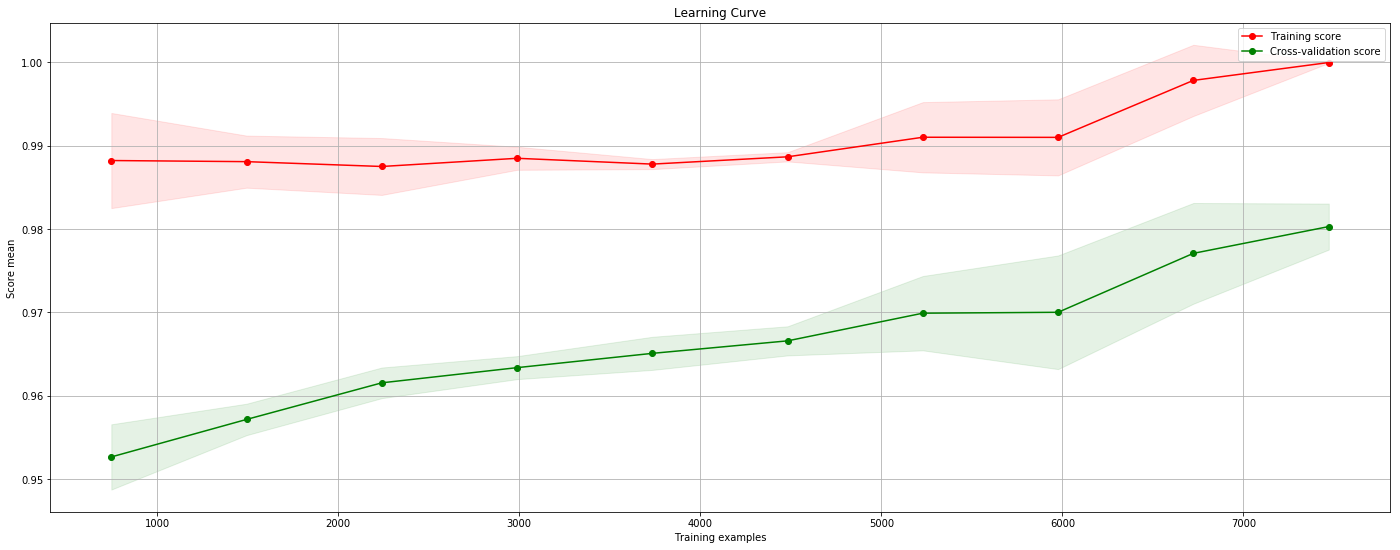

In [16]:
figure = plt.gcf()
figure.set_size_inches(24, 9)
skplot.learning_curve(train_scores, test_scores, train_sizes)
plt.show()